# Developing Mouse - Visual Cortex 10X scRNASeq analysis: clustering and annotations

The Developing Mouse - Visual Cortex taxonomy is derived from a single cell transcriptomic dataset containing 568,654 cells from donors ranging in age from embryonic to adult. The cell-type assignment is a four level taxonomy defining 15 classes, 40 subclasses, 148 clusters and 714 subclusters. This cell-type assignment is broadly consistent with those from the previous studies from the [Allen Institute for Brain Science, Whole Mouse Brain (WMB)](https://alleninstitute.github.io/abc_atlas_access/descriptions/WMB-taxonomy.html) and the [Broad Institute whole mouse brain taxonomy](https://alleninstitute.github.io/abc_atlas_access/descriptions/Consensus-WMB-taxonomy.html) at the subclass level while providing finer cell-type and temporal resolutions with additional subcluster annotations.

To generate this developing taxonomy, we applied the Quality Control (QC) and post-integration QC pipelines. Integration and label transfer of scRNA-seq between ages was performed using Seurat/scVI. A detailed cell type annotation table accompanies the taxonomy, including hierarchical membership and anatomical localization.

You need to be connected to the internet to run this notebook or connected to a cache that has the Developing Mouse data downloaded already.

The notebook presented here shows quick visualizations from precomputed metadata in the atlas, exploring both cell, donor, and library metadata as well as the taxonomy. We also plot visualizations for the various data and metadata in a Uniform Manifold Approximation and Projection (UMAP). For examples on accessing the expression matrices, specifically selecting genes from expression matrices, see the  [``general_accessing_10x_snRNASeq_tutorial.ipynb``](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html) tutorial/example. In a related tutorial, we also show how to access and use [Developing Mouse - Visual Cortex gene expression data](https://alleninstitute.github.io/abc_atlas_access/notebooks/dev_mouse_vis_cortex_10X_scRNASeq.html).

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object downloads data requested by the user, tracks which files have already been downloaded to your local system, and serves the path to the requested data on disk. For metadata, the cache can also directly serve up a Pandas DataFrame. See the [``getting_started``](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html) notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you would like to download the data in your system or a location where a cache is already available.**

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(
    download_base,
)

abc_cache.current_manifest

'releases/20260131/manifest.json'

## Data overview


We'll quickly walk through the data we will be using in this notebook. The Developing Mouse 10X dataset is located across two directories listed in the `ABCProjectCache`. These data are the metadata and data for the cells and the metadata defining the taxonomy. We will be using data and metadata from the following directories:
- Developing-Mouse-Vis-Cortex-10X
- Developing-Mouse-Vis-Cortex-taxonomy

Below we list the data and metadata in the Developing Mouse dataset.

In [3]:
print("Developing-Mouse-Vis-Cortex-10X: gene expression data (h5ad)\n\t", abc_cache.list_expression_matrix_files(directory='Developing-Mouse-Vis-Cortex-10X'))
print("Developing-Mouse-Vis-Cortex-10X: metadata (csv)\n\t", abc_cache.list_metadata_files(directory='Developing-Mouse-Vis-Cortex-10X'))

Developing-Mouse-Vis-Cortex-10X: gene expression data (h5ad)
	 ['Developing-Mouse-Vis-Cortex-10X/log2', 'Developing-Mouse-Vis-Cortex-10X/raw']
Developing-Mouse-Vis-Cortex-10X: metadata (csv)
	 ['cell_metadata', 'donor', 'example_gene_expression', 'gene', 'library', 'value_sets']


We will also use metadata from the Developing-Mouse-Vis-Cortex-taxonomy directory. Below is the list of available files:

In [4]:
print("Developing-Mouse-Vis-Cortex-taxonomy: metadata (csv)\n\t", abc_cache.list_metadata_files(directory='Developing-Mouse-Vis-Cortex-taxonomy'))

Developing-Mouse-Vis-Cortex-taxonomy: metadata (csv)
	 ['cell_2d_embedding_coordinates', 'cell_to_cluster_membership', 'cluster', 'cluster_annotation_term', 'cluster_annotation_term_set', 'cluster_to_cluster_annotation_membership', 'de_genes']


### Cell metadata

Essential cell metadata is stored as a CSV file that we load as a Pandas DataFrame. Each row represents one cell indexed by a *cell label*. The *cell label* is the concatenation of barcode and name of the sample. In this context, the sample is the *barcoded cell sample* that represents a single load into one port of the 10x Chromium. Note that cell barcodes are only unique within a single *barcoded cell sample* and that the same barcode can be reused.

Each cell is associated with a *library label*, *donor label*, *alignment_job_id*, *feature_matrix_label* and *dataset_label* identifying which data package this cell is part of. This metadata file will be combined with other metadata files that ship with this package to add information associated with the donor, UMAP coordinates, taxonomy assignments, and more.

Below, we load the first of the metadata used in this tutorial. This represents the cell metadata for the aligned dataset.

The command we use below both downloads the data if it is not already available in the local cache and loads the data as a Pandas DataFrame. This pattern of loading metadata is repeated throughout the tutorials.

In [5]:
cell = abc_cache.get_metadata_dataframe(
    directory='Developing-Mouse-Vis-Cortex-10X',
    file_name='cell_metadata'
).set_index('cell_label')
print("Number of cells = ", len(cell))
cell.head()

cell_metadata.csv: 100%|██████████| 105M/105M [00:03<00:00, 30.0MMB/s]   


Number of cells =  568654


cell_barcode barcoded_cell_sample_label  \
cell_label                                                              
AAACCCAAGGATTTAG-898_A02  AAACCCAAGGATTTAG                    898_A02   
AAACCCACACATTCTT-898_A02  AAACCCACACATTCTT                    898_A02   
AAACCCACACTTACAG-898_A02  AAACCCACACTTACAG                    898_A02   
AAACGAATCACTCTTA-898_A02  AAACGAATCACTCTTA                    898_A02   
AAACGAATCGACCAAT-898_A02  AAACGAATCGACCAAT                    898_A02   

                               library_label  alignment_id  log.qc.score.cr6  \
cell_label                                                                     
AAACCCAAGGATTTAG-898_A02  L8TX_211028_01_G04    1157582505        338.986629   
AAACCCACACATTCTT-898_A02  L8TX_211028_01_G04    1157582505        425.642457   
AAACCCACACTTACAG-898_A02  L8TX_211028_01_G04    1157582505        342.366675   
AAACGAATCACTCTTA-898_A02  L8TX_211028_01_G04    1157582505        353.204604   
AAACGAATCGACCAAT-898_A02  L8TX_211028_01_G04    1157582505        355.052147   

                         synchronized_age     donor_label  \
cell_label                                                  
AAACCCAAGGATTTAG-898_A02            E13.5  C67BL6J-606627   
AAACCCACACATTCTT-898_A02            E13.5  C67BL6J-606627   
AAACCCACACTTACAG-898_A02            E13.5  C67BL6J-606627   
AAACGAATCACTCTTA-898_A02            E13.5  C67BL6J-606627   
AAACGAATCGACCAAT-898_A02            E13.5  C67BL6J-606627   

                                            dataset_label  \
cell_label                                                  
AAACCCAAGGATTTAG-898_A02  Developing-Mouse-Vis-Cortex-10X   
AAACCCACACATTCTT-898_A02  Developing-Mouse-Vis-Cortex-10X   
AAACCCACACTTACAG-898_A02  Developing-Mouse-Vis-Cortex-10X   
AAACGAATCACTCTTA-898_A02  Developing-Mouse-Vis-Cortex-10X   
AAACGAATCGACCAAT-898_A02  Developing-Mouse-Vis-Cortex-10X   

                                     feature_matrix_label  
cell_label                                                 
AAACCCAAGGATTTAG-898_A02  Developing-Mouse-Vis-Cortex-10X  
AAACCCACACATTCTT-898_A02  Developing-Mouse-Vis-Cortex-10X  
AAACCCACACTTACAG-898_A02  Developing-Mouse-Vis-Cortex-10X  
AAACGAATCACTCTTA-898_A02  Developing-Mouse-Vis-Cortex-10X  
AAACGAATCGACCAAT-898_A02  Developing-Mouse-Vis-Cortex-10X

We can use pandas `groupby` function to see how many unique items are associated for each field and list them out if the number of unique items is small.

In [6]:
def print_column_info(df):
    
    for c in df.columns:
        grouped = df[[c]].groupby(c).count()
        members = ''
        if len(grouped) < 30:
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c, len(grouped), members))

In [7]:
print_column_info(cell)

Number of unique cell_barcode = 527176 
Number of unique barcoded_cell_sample_label = 91 
Number of unique library_label = 91 
Number of unique alignment_id = 91 
Number of unique log.qc.score.cr6 = 496566 
Number of unique synchronized_age = 35 
Number of unique donor_label = 53 
Number of unique dataset_label = 1 ['Developing-Mouse-Vis-Cortex-10X']
Number of unique feature_matrix_label = 1 ['Developing-Mouse-Vis-Cortex-10X']


### Donor and Library metadata

The first two associated metadata we load are the `donor` and `library` tables. The donor table contains species, sex, and age information. The library table contains information on 10X methods and brain region of interest the tissue was extracted from.

Below we load the donor metadata. Note that we flatten the values of P54 and above to P56 or "Adult" to match the published analysis. The original age values are available in the donor table. 

In [8]:
donor = abc_cache.get_metadata_dataframe(
    directory='Developing-Mouse-Vis-Cortex-10X',
    file_name='donor'
).set_index('donor_label')

for idx, row in donor.iterrows():
    if row['donor_age'] in ['P54', 'P59', 'P60', 'P61', 'P68']:
        donor.loc[idx, 'donor_age'] = 'P56'

donor.head()

donor.csv:   0%|          | 0.00/5.08k [00:00<?, ?MB/s]

donor.csv: 100%|██████████| 5.08k/5.08k [00:00<00:00, 96.1kMB/s]


donor_species species_scientific_name species_genus  \
donor_label                                                             
C57BL6J-603767  NCBITaxon:10090            Mus musculus         Mouse   
C57BL6J-620146  NCBITaxon:10090            Mus musculus         Mouse   
C57BL6J-628080  NCBITaxon:10090            Mus musculus         Mouse   
C57BL6J-628083  NCBITaxon:10090            Mus musculus         Mouse   
C57BL6J-628825  NCBITaxon:10090            Mus musculus         Mouse   

               donor_sex  donor_age_value donor_age_unit  \
donor_label                                                
C57BL6J-603767      Male             18.5           days   
C57BL6J-620146      Male              9.0           days   
C57BL6J-628080      Male             13.5           days   
C57BL6J-628083      Male             13.5           days   
C57BL6J-628825    Female             18.0           days   

               donor_age_reference_point donor_age      age_bin  
donor_label                                                      
C57BL6J-603767                conception     E18.5    E17_E18.5  
C57BL6J-620146                     birth        P9            9  
C57BL6J-628080                conception     E13.5  E13.5_E16.5  
C57BL6J-628083                conception     E13.5  E13.5_E16.5  
C57BL6J-628825                conception       E18    E17_E18.5

Next we load the library metadata. The information we will primarily use from this table are the region of interest that each library is associated with

In [9]:
library = abc_cache.get_metadata_dataframe(
    directory='Developing-Mouse-Vis-Cortex-10X',
    file_name='library'
).set_index('library_label')
library.head()

library.csv: 100%|██████████| 11.2k/11.2k [00:00<00:00, 138kMB/s]


library_technique barcoded_cell_sample_label  \
library_label                                                     
L8TX_200618_01_D07   10xV3.1;GEXOnly                    265_B02   
L8TX_200618_01_F06   10xV3.1;GEXOnly                    264_A01   
L8TX_200618_01_G05   10xV3.1;GEXOnly                    264_B01   
L8TX_200618_01_H05   10xV3.1;GEXOnly                    265_A02   
L8TX_200709_01_B03   10xV3.1;GEXOnly                    282_B02   

                             enrichment_population cell_specimen_type  \
library_label                                                           
L8TX_200618_01_D07                         No FACS              Cells   
L8TX_200618_01_F06  RFP-positive, Hoechst-positive              Cells   
L8TX_200618_01_G05  RFP-positive, Hoechst-positive              Cells   
L8TX_200618_01_H05                         No FACS              Cells   
L8TX_200709_01_B03                         No FACS              Cells   

                   parcellation_term_identifier region_of_interest_name  \
library_label                                                             
L8TX_200618_01_D07                      MBA:385     Primary visual area   
L8TX_200618_01_F06                      MBA:385     Primary visual area   
L8TX_200618_01_G05                      MBA:385     Primary visual area   
L8TX_200618_01_H05                      MBA:385     Primary visual area   
L8TX_200709_01_B03                      MBA:385     Primary visual area   

                   region_of_interest_label                   donor_label  
library_label                                                              
L8TX_200618_01_D07                     VISp  Snap25-IRES2-Cre;Ai14-536764  
L8TX_200618_01_F06                     VISp  Snap25-IRES2-Cre;Ai14-536763  
L8TX_200618_01_G05                     VISp  Snap25-IRES2-Cre;Ai14-536763  
L8TX_200618_01_H05                     VISp  Snap25-IRES2-Cre;Ai14-536764  
L8TX_200709_01_B03                     VISp  Snap25-IRES2-Cre;Ai14-538743

We combine the donor and library tables into an extended cell metadata table.

In [10]:
cell_extended = cell.join(donor, on='donor_label')
cell_extended = cell_extended.join(library, on='library_label', rsuffix='_library_table')

del cell

We use the `groupby` function to show the number of cells in each region of interest.

In [11]:
cell_extended.groupby('region_of_interest_name')[['region_of_interest_label']].count()

region_of_interest_label
region_of_interest_name                                                     
Cerebrum - Brain stem                                                  12813
Primary visual area                                                   128550
Visual areas                                                          387480
Visual areas - Posterior parietal association a...                     25539
brain                                                                  14272

We can use the group by functionality to group the cells by each age.

In [12]:
cell_extended.groupby('age_bin')[['library_label']].count().rename(columns={'library_label': 'number_of_cells'}).loc[
    ['E11.5_E12.5', 'E13.5_E16.5', 'E17_E18.5',
     '0_1', '2', '3', '4', '5_6', '7_8', '9', '10',
     '11', '12_13', '14_15', '16', '17_19', '20_28', '54_68']]

number_of_cells
age_bin                     
E11.5_E12.5            17222
E13.5_E16.5            19762
E17_E18.5              22970
0_1                    28315
2                      23329
3                      17953
4                      12744
5_6                    13356
7_8                    31637
9                      31973
10                     12146
11                     11885
12_13                  54048
14_15                  76385
16                     24198
17_19                  28877
20_28                  68990
54_68                  72864

### Adding color and feature order

Each major feature in the donor and library table is associated with unique colors and an ordering with the set of values. Below we load the `value_sets` DataFrame which is a mapping from the various value in the donor and species tables to those colors and orderings. We incorporate these values into the cell metadata table. 

In [13]:
value_sets = abc_cache.get_metadata_dataframe(
    directory='Developing-Mouse-Vis-Cortex-10X',
    file_name='value_sets'
).set_index('label')
value_sets

value_sets.csv: 100%|██████████| 4.33k/4.33k [00:00<00:00, 66.6kMB/s]


table                     field      description  order  \
label                                                                     
Female          donor                 donor_sex           Female      1   
Male            donor                 donor_sex             Male      2   
Mouse           donor             species_genus            Mouse      1   
Mus musculus    donor   species_scientific_name     Mus musculus      1   
WholeBrain    library  region_of_interest_label            brain      1   
...               ...                       ...              ...    ...   
14_15           donor                   age_bin  age bin in days     14   
16              donor                   age_bin  age bin in days     15   
17_19           donor                   age_bin  age bin in days     16   
20_28           donor                   age_bin  age bin in days     17   
54_68           donor                   age_bin  age bin in days     18   

             external_identifier parent_label color_hex_triplet  
label                                                            
Female                       NaN          NaN           #565353  
Male                         NaN          NaN           #ADC4C3  
Mouse            NCBITaxon:10088          NaN           #c941a7  
Mus musculus     NCBITaxon:10090          NaN           #ffa300  
WholeBrain               MBA:997          NaN           #bebebe  
...                          ...          ...               ...  
14_15                        NaN          NaN           #2C49AD  
16                           NaN          NaN           #0F0F99  
17_19                        NaN          NaN           #6B49F9  
20_28                        NaN          NaN           #AE43C6  
54_68                        NaN          NaN           #C30000  

[68 rows x 7 columns]

We define a convenience function to add colors for the various values in the data (e.g. unique region of interest or donor sex values).

In [14]:
def extract_value_set(
        cell_metadata_df: pd.DataFrame,
        input_value_set: pd.DataFrame,
        input_value_set_label: str,
        dataframe_column: Optional[str] = None
    ):
    """Add color and order columns to the cell metadata dataframe based on the input
    value set.

    Columns are added as {input_value_set_label}_color and {input_value_set_label}_order.

    Parameters
    ----------
    cell_metadata_df : pd.DataFrame
        DataFrame containing cell metadata.
    input_value_set : pd.DataFrame
        DataFrame containing the value set information.
    input_value_set_label : str
        The the column name to extract color and order information for. will be added to the cell metadata.
    """
    if dataframe_column is None:
        dataframe_column = input_value_set_label
    cell_metadata_df[f'{dataframe_column}_color'] = input_value_set[
        input_value_set['field'] == input_value_set_label
    ].loc[cell_metadata_df[dataframe_column]]['color_hex_triplet'].values
    cell_metadata_df[f'{dataframe_column}_order'] = input_value_set[
        input_value_set['field'] == input_value_set_label
    ].loc[cell_metadata_df[dataframe_column]]['order'].values

Use our function to add the relevant color and order columns to our cell_metadata table.

In [15]:
# Add region of interest color and order
extract_value_set(cell_extended, value_sets, 'region_of_interest_label')
# Add region of interest color and order
extract_value_set(cell_extended, value_sets, 'synchronized_age', 'donor_age')
extract_value_set(cell_extended, value_sets, 'synchronized_age')
# Add region of interest color and order
extract_value_set(cell_extended, value_sets, 'age_bin')
# Add species common name color and order
extract_value_set(cell_extended, value_sets, 'species_genus')
# Add species scientific name color and order
extract_value_set(cell_extended, value_sets, 'species_scientific_name')
# Add donor sex color and order
extract_value_set(cell_extended, value_sets, 'donor_sex')
cell_extended.head()

cell_barcode barcoded_cell_sample_label  \
cell_label                                                              
AAACCCAAGGATTTAG-898_A02  AAACCCAAGGATTTAG                    898_A02   
AAACCCACACATTCTT-898_A02  AAACCCACACATTCTT                    898_A02   
AAACCCACACTTACAG-898_A02  AAACCCACACTTACAG                    898_A02   
AAACGAATCACTCTTA-898_A02  AAACGAATCACTCTTA                    898_A02   
AAACGAATCGACCAAT-898_A02  AAACGAATCGACCAAT                    898_A02   

                               library_label  alignment_id  log.qc.score.cr6  \
cell_label                                                                     
AAACCCAAGGATTTAG-898_A02  L8TX_211028_01_G04    1157582505        338.986629   
AAACCCACACATTCTT-898_A02  L8TX_211028_01_G04    1157582505        425.642457   
AAACCCACACTTACAG-898_A02  L8TX_211028_01_G04    1157582505        342.366675   
AAACGAATCACTCTTA-898_A02  L8TX_211028_01_G04    1157582505        353.204604   
AAACGAATCGACCAAT-898_A02  L8TX_211028_01_G04    1157582505        355.052147   

                         synchronized_age     donor_label  \
cell_label                                                  
AAACCCAAGGATTTAG-898_A02            E13.5  C67BL6J-606627   
AAACCCACACATTCTT-898_A02            E13.5  C67BL6J-606627   
AAACCCACACTTACAG-898_A02            E13.5  C67BL6J-606627   
AAACGAATCACTCTTA-898_A02            E13.5  C67BL6J-606627   
AAACGAATCGACCAAT-898_A02            E13.5  C67BL6J-606627   

                                            dataset_label  \
cell_label                                                  
AAACCCAAGGATTTAG-898_A02  Developing-Mouse-Vis-Cortex-10X   
AAACCCACACATTCTT-898_A02  Developing-Mouse-Vis-Cortex-10X   
AAACCCACACTTACAG-898_A02  Developing-Mouse-Vis-Cortex-10X   
AAACGAATCACTCTTA-898_A02  Developing-Mouse-Vis-Cortex-10X   
AAACGAATCGACCAAT-898_A02  Developing-Mouse-Vis-Cortex-10X   

                                     feature_matrix_label    donor_species  \
cell_label                                                                   
AAACCCAAGGATTTAG-898_A02  Developing-Mouse-Vis-Cortex-10X  NCBITaxon:10090   
AAACCCACACATTCTT-898_A02  Developing-Mouse-Vis-Cortex-10X  NCBITaxon:10090   
AAACCCACACTTACAG-898_A02  Developing-Mouse-Vis-Cortex-10X  NCBITaxon:10090   
AAACGAATCACTCTTA-898_A02  Developing-Mouse-Vis-Cortex-10X  NCBITaxon:10090   
AAACGAATCGACCAAT-898_A02  Developing-Mouse-Vis-Cortex-10X  NCBITaxon:10090   

                          ... synchronized_age_color synchronized_age_order  \
cell_label                ...                                                 
AAACCCAAGGATTTAG-898_A02  ...                #E6865C                      3   
AAACCCACACATTCTT-898_A02  ...                #E6865C                      3   
AAACCCACACTTACAG-898_A02  ...                #E6865C                      3   
AAACGAATCACTCTTA-898_A02  ...                #E6865C                      3   
AAACGAATCGACCAAT-898_A02  ...                #E6865C                      3   

                         age_bin_color  age_bin_order species_genus_color  \
cell_label                                                                  
AAACCCAAGGATTTAG-898_A02       #D38F38              2             #c941a7   
AAACCCACACATTCTT-898_A02       #D38F38              2             #c941a7   
AAACCCACACTTACAG-898_A02       #D38F38              2             #c941a7   
AAACGAATCACTCTTA-898_A02       #D38F38              2             #c941a7   
AAACGAATCGACCAAT-898_A02       #D38F38              2             #c941a7   

                         species_genus_order species_scientific_name_color  \
cell_label                                                                   
AAACCCAAGGATTTAG-898_A02                   1                       #ffa300   
AAACCCACACATTCTT-898_A02                   1                       #ffa300   
AAACCCACACTTACAG-898_A02                   1                       #ffa300   
AAACGAATCACTCTTA-898_A02                   1                       #ff

### UMAP spatial embedding

Now that we've merged our donor and library metadata into the main cells data, our next step is to plot these values in the Uniform Manifold Approximation and Projection (UMAP) for cells in the dataset. The UMAP is a dimension reduction technique that can be used for visualizing and exploring large-dimension datasets. 

Below we load this 2-D embedding for a sub selection of our cells and merge the x-y coordinates into the extended cell metadata we are creating. 

In [16]:
cell_2d_embedding_coordinates = abc_cache.get_metadata_dataframe(
    directory='Developing-Mouse-Vis-Cortex-taxonomy',
    file_name='cell_2d_embedding_coordinates'
).set_index('cell_label')
cell_2d_embedding_coordinates.head()

cell_2d_embedding_coordinates.csv: 100%|██████████| 25.7M/25.7M [00:00<00:00, 31.2MMB/s]


x         y
cell_label                                   
AAACCCAAGGATTTAG-898_A02  17.504883  4.327579
AAACCCACACATTCTT-898_A02   9.755900  5.404129
AAACCCACACTTACAG-898_A02  10.902691  4.540480
AAACGAATCACTCTTA-898_A02  13.066967  4.577918
AAACGAATCGACCAAT-898_A02  18.801212 -2.231872

In [17]:
cell_extended = cell_extended.join(cell_2d_embedding_coordinates)
cell_extended = cell_extended.sample(frac=1) # shuffle the rows for plotting purposes

del cell_2d_embedding_coordinates

We define a small helper function *plot_umap* to visualize the cells on the UMAP. In the examples below we will plot associated cell information colorized by donor age, sex, and region of interest.

In [18]:
def plot_umap(
    xx: np.ndarray,
    yy: np.ndarray,
    cc: np.ndarray = None,
    val: np.ndarray = None,
    fig_width: float = 8,
    fig_height: float = 8,
    cmap: Optional[plt.Colormap] = None,
    labels: np.ndarray = None,
    term_orders: np.ndarray = None,
    colorbar: bool = False,
    sizes: np.ndarray = None
 ) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot a scatter plot of the UMAP coordinates.

    Parameters
    ----------
    xx : array-like
        x-coordinates of the points to plot.
    yy : array-like
        y-coordinates of the points to plot.
    cc : array-like, optional
        colors of the points to plot. If None, the points will be colored by the values in `val`.
    val : array-like, optional
        values of the points to plot. If None, the points will be colored by the values in `cc`.
    fig_width : float, optional
        width of the figure in inches. Default is 8.
    fig_height : float, optional
        height of the figure in inches. Default is 8.
    cmap : str, optional
        colormap to use for coloring the points. If None, the points will be colored by the values in `cc`.
    labels : array-like, optional
        labels for the points to plot. If None, no labels will be added to the plot.
    term_orders : array-like, optional
        order of the labels for the legend. If None, the labels will be ordered by their appearance in `labels`.
    colorbar : bool, optional
        whether to add a colorbar to the plot. Default is False.
    sizes : array-like, optional
        sizes of the points to plot. If None, all points will have the same size.
    """
    if sizes is None:
        sizes = 1
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if cmap is not None:
        scatt = ax.scatter(xx, yy, c=val, s=0.5, marker='.', cmap=cmap, alpha=sizes)
    elif cc is not None:
        scatt = ax.scatter(xx, yy, c=cc, s=0.5, marker='.', alpha=sizes)

    if labels is not None:
        from matplotlib.patches import Rectangle
        unique_label_colors = (labels + ',' + cc).unique()
        unique_labels = np.array([label_color.split(',')[0] for label_color in unique_label_colors])
        unique_colors = np.array([label_color.split(',')[1] for label_color in unique_label_colors])

        if term_orders is not None:
            unique_order = term_orders.unique()
            term_order = np.argsort(unique_order)
            unique_labels = unique_labels[term_order]
            unique_colors = unique_colors[term_order]
            
        rects = []
        for color in unique_colors:
            rects.append(Rectangle((0, 0), 1, 1, fc=color))

        legend = ax.legend(rects, unique_labels, loc=1)
        # ax.add_artist(legend)

    if colorbar:
        fig.colorbar(scatt, ax=ax)
    
    return fig, ax

Plot the various donor and library metadata available.

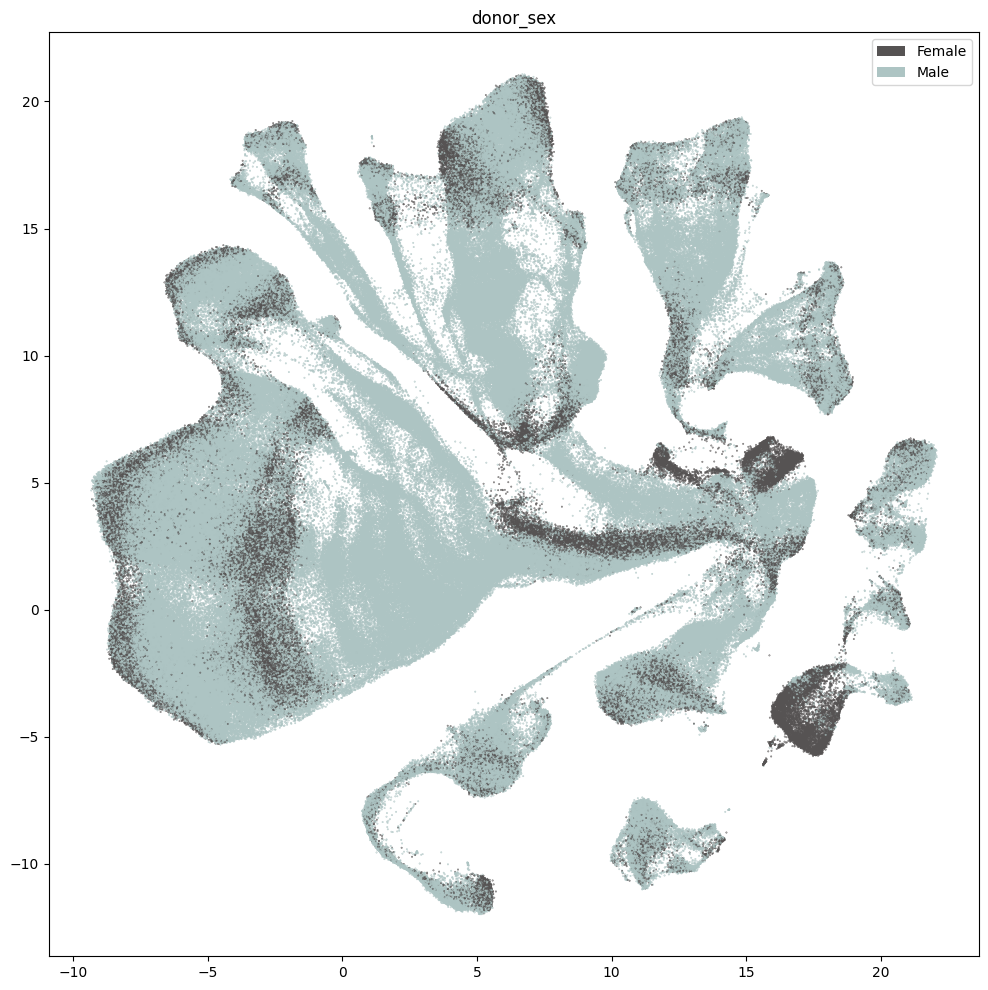

In [19]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['donor_sex_color'],
    labels=cell_extended['donor_sex'],
    term_orders=cell_extended['donor_sex_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("donor_sex")
plt.show()

Below we show the region of interest for the cells in the dataset.

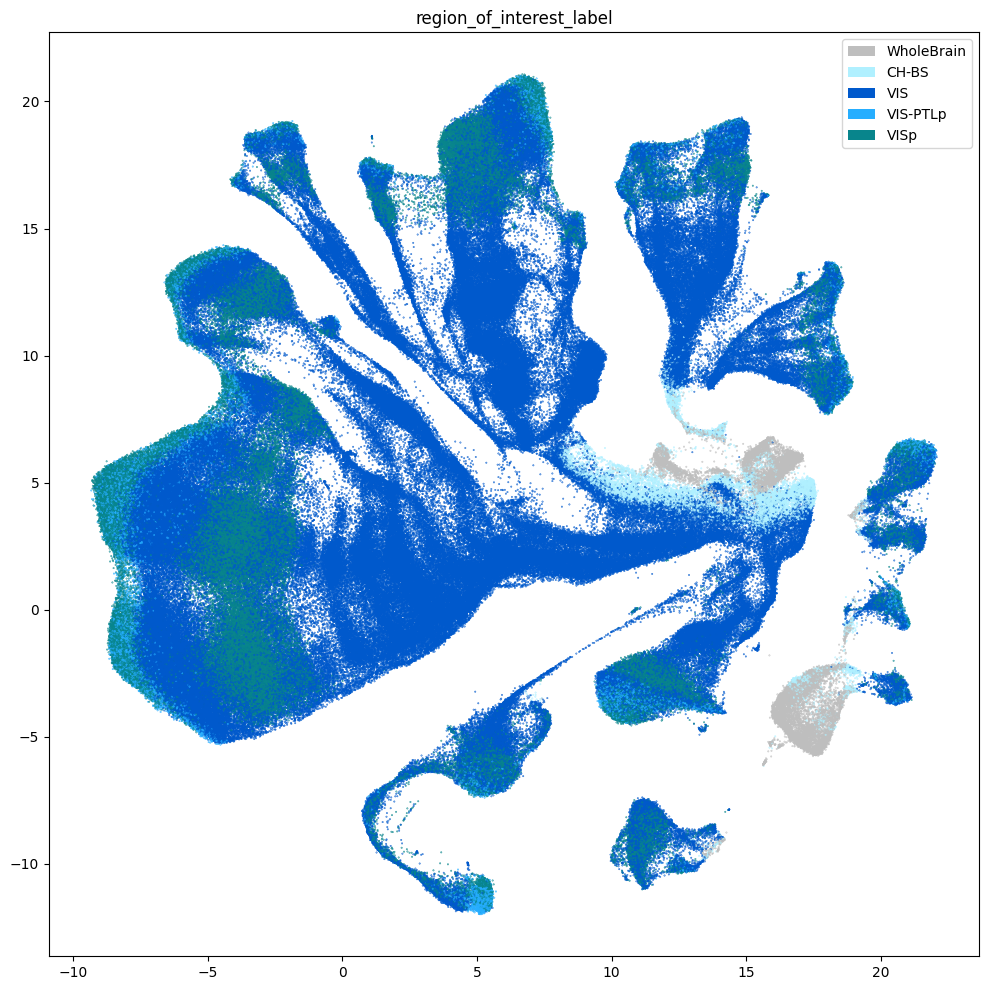

In [20]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['region_of_interest_label_color'],
    labels=cell_extended['region_of_interest_label'],
    term_orders=cell_extended['region_of_interest_label_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("region_of_interest_label")
plt.show()

The UMAP with donor age.

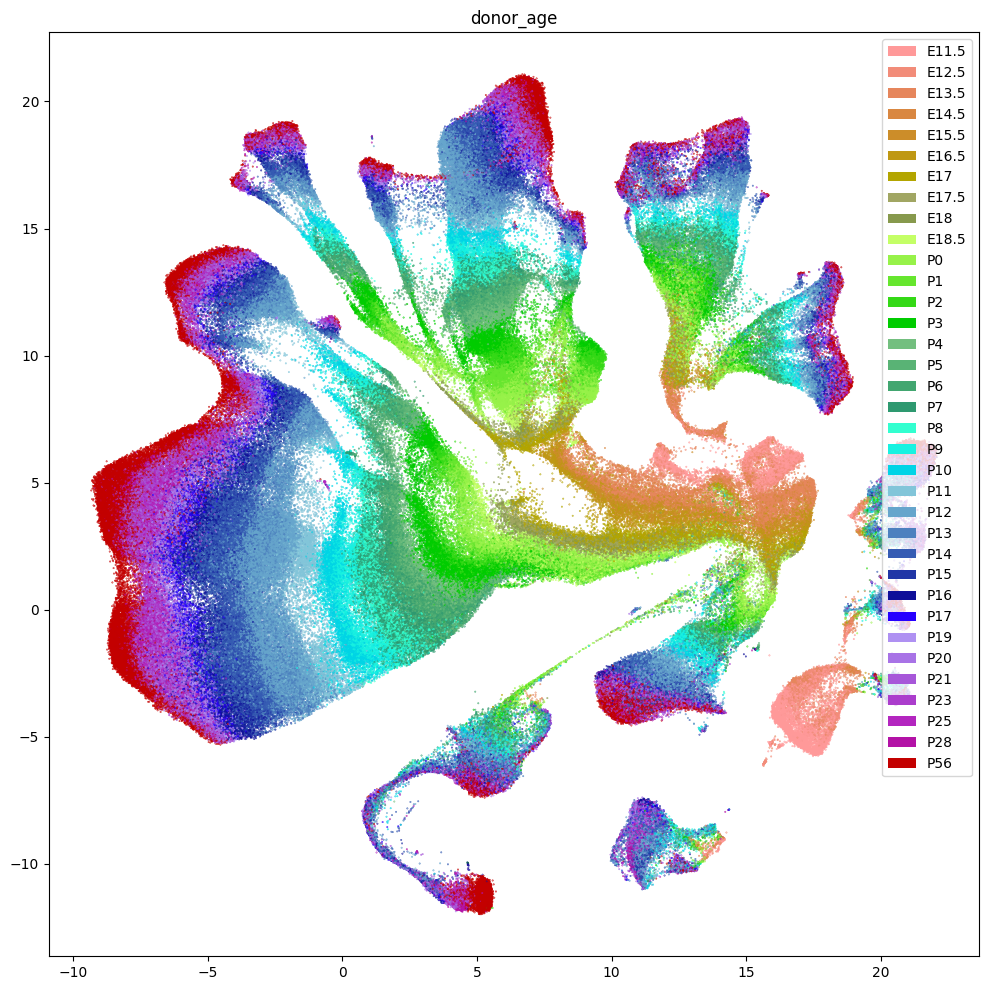

In [21]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['donor_age_color'],
    labels=cell_extended['donor_age'],
    term_orders=cell_extended['donor_age_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("donor_age")
plt.show()

## Taxonomy Information

The final set of metadata we load into our extended cell metadata file maps the cells into their assigned cluster in the taxonomy. We additionally load metadata for the clusters and compute useful information, such as the number of cells in each taxon at each level of the taxonomy.

First, we load information associated with the lowest level in the taxonomy in the taxonomy. This includes a useful alias value for each cluster as well as the number of cells in each subcluster.

In [22]:
cluster = abc_cache.get_metadata_dataframe(
    directory='Developing-Mouse-Vis-Cortex-taxonomy',
    file_name='cluster',
    dtype={'number_of_cells': 'Int64'}
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')
cluster.head()

cluster.csv: 100%|██████████| 20.5k/20.5k [00:00<00:00, 210kMB/s]


cluster_alias  number_of_cells
cluster_annotation_term_label                                
CS20260131_SCLU_0001                       1               77
CS20260131_SCLU_0002                       2              126
CS20260131_SCLU_0003                       3              184
CS20260131_SCLU_0004                       4              186
CS20260131_SCLU_0005                       5               25

Next, we load the table that describes the levels in the taxonomy from class at the highest to subcluster at the lowest level.

In [23]:
cluster_annotation_term_set = abc_cache.get_metadata_dataframe(
    directory='Developing-Mouse-Vis-Cortex-taxonomy',
    file_name='cluster_annotation_term_set'
).rename(columns={'label': 'cluster_annotation_term_label'})
cluster_annotation_term_set

cluster_annotation_term_set.csv: 100%|██████████| 268/268 [00:00<00:00, 2.76kMB/s]


name cluster_annotation_term_label description  order  \
0       class           CCN20260131_LEVEL_0       class      0   
1    subclass           CCN20260131_LEVEL_1    subclass      1   
2     cluster           CCN20260131_LEVEL_2     cluster      2   
3  subcluster           CCN20260131_LEVEL_3  subcluster      3   

  parent_term_set_label  
0                   NaN  
1   CCN20260131_LEVEL_0  
2   CCN20260131_LEVEL_1  
3   CCN20260131_LEVEL_2

For the subclusters, we load information on the annotations for each subcluster. This also includes the term order and color information which we will use to plot later. Note the inclusion of the `CCN20230722_label` column. This value points to the equivalent taxon in the [Whole Mouse Brain taxonomy](https://alleninstitute.github.io/abc_atlas_access/descriptions/WMB-taxonomy.html) if it exists.

In [24]:
cluster_annotation_term = abc_cache.get_metadata_dataframe(
    directory='Developing-Mouse-Vis-Cortex-taxonomy',
    file_name='cluster_annotation_term',
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')
cluster_annotation_term

cluster_annotation_term.csv: 100%|██████████| 129k/129k [00:00<00:00, 1.10MMB/s]


name cluster_annotation_term_set_label  \
cluster_annotation_term_label                                                   
CS20260131_CLAS_009              Astro-Epen               CCN20260131_LEVEL_0   
CS20260131_CLAS_013            CNU-MGE GABA               CCN20260131_LEVEL_0   
CS20260131_CLAS_002                 CR Glut               CCN20260131_LEVEL_0   
CS20260131_CLAS_011            CTX-CGE GABA               CCN20260131_LEVEL_0   
CS20260131_CLAS_012            CTX-MGE GABA               CCN20260131_LEVEL_0   
...                                     ...                               ...   
CS20260131_SCLU_051                    RG_5               CCN20260131_LEVEL_3   
CS20260131_SCLU_052                    RG_6               CCN20260131_LEVEL_3   
CS20260131_SCLU_053                    RG_7               CCN20260131_LEVEL_3   
CS20260131_SCLU_054                    RG_8               CCN20260131_LEVEL_3   
CS20260131_SCLU_055                    RG_9               CCN20260131_LEVEL_3   

                              cluster_annotation_term_set_name  \
cluster_annotation_term_label                                    
CS20260131_CLAS_009                                      class   
CS20260131_CLAS_013                                      class   
CS20260131_CLAS_002                                      class   
CS20260131_CLAS_011                                      class   
CS20260131_CLAS_012                                      class   
...                                                        ...   
CS20260131_SCLU_051                                 subcluster   
CS20260131_SCLU_052                                 subcluster   
CS20260131_SCLU_053                                 subcluster   
CS20260131_SCLU_054                                 subcluster   
CS20260131_SCLU_055                                 subcluster   

                              color_hex_triplet  term_order  term_set_order  \
cluster_annotation_term_label                                                 
CS20260131_CLAS_009                     #594a26           9               0   
CS20260131_CLAS_013                     #450099          13               0   
CS20260131_CLAS_002                     #919900           2               0   
CS20260131_CLAS_011                     #CCFF33          11               0   
CS20260131_CLAS_012                     #f954ee          12               0   
...                                         ...         ...             ...   
CS20260131_SCLU_051                     #9e9ac8          51               3   
CS20260131_SCLU_052                     #bcbddc          52               3   
CS20260131_SCLU_053                     #dadaeb          53               3   
CS20260131_SCLU_054                     #636363          54               3   
CS20260131_SCLU_055                     #969696          55               3   

                                 parent_term_label parent_term_name  \
cluster_annotation_term_label                                         
CS20260131_CLAS_009                            NaN              NaN   
CS20260131_CLAS_013                            NaN              NaN   
CS20260131_CLAS_002                            NaN              NaN   
CS20260131_CLAS_011                            NaN              NaN   
CS20260131_CLAS_012                            NaN              NaN   
...                                            ...              ...   
CS20260131_SCLU_051            CS20260131_CLUS_004               RG   
CS20260131_SCLU_052            CS20260131_CLUS_004               RG   
CS20260131_SCLU_053            CS20260131_CLUS_004               RG   
CS20260131_SCLU_054            CS20260131_CLUS_004               RG   
CS20260131_SCLU_055            CS20260131_CLUS_004               RG   

                              parent_term_set_label   CCN20230722_label  
cluster_annotation_term_label                                            
CS20260131_CLAS_009       

Finally, we load the cluster to cluster annotation membership table. Each row in this table is a mapping between the subclusters and every level of the taxonomy it belongs to, including itself. We'll use this table in a `groupby` to allow us to count up the number of clusters at each taxonomy level and sum the number of cells in each taxon in the taxonomy a all levels.

In [25]:
cluster_to_cluster_annotation_membership = abc_cache.get_metadata_dataframe(
    directory='Developing-Mouse-Vis-Cortex-taxonomy',
    file_name='cluster_to_cluster_annotation_membership'
).set_index('cluster_annotation_term_label')
membership_with_cluster_info = cluster_to_cluster_annotation_membership.join(
    cluster.reset_index().set_index('cluster_alias')[['number_of_cells']],
    on='cluster_alias'
)
membership_with_cluster_info = membership_with_cluster_info.join(cluster_annotation_term, rsuffix='_anno_term').reset_index()
membership_groupby = membership_with_cluster_info.groupby(
    ['cluster_alias', 'cluster_annotation_term_set_name']
)
membership_with_cluster_info.head()

cluster_to_cluster_annotation_membership.csv:   0%|          | 0.00/189k [00:00<?, ?MB/s]

cluster_to_cluster_annotation_membership.csv: 100%|██████████| 189k/189k [00:00<00:00, 1.45MMB/s] 


cluster_annotation_term_label cluster_annotation_term_set_name  \
0           CS20260131_CLAS_001                            class   
1           CS20260131_CLAS_001                            class   
2           CS20260131_CLAS_001                            class   
3           CS20260131_CLAS_001                            class   
4           CS20260131_CLAS_001                            class   

  cluster_annotation_term_name  cluster_alias  \
0                          NEC              1   
1                          NEC              2   
2                          NEC              3   
3                          NEC              4   
4                          NEC              5   

  cluster_annotation_term_set_label  number_of_cells name  \
0               CCN20260131_LEVEL_0               77  NEC   
1               CCN20260131_LEVEL_0              126  NEC   
2               CCN20260131_LEVEL_0              184  NEC   
3               CCN20260131_LEVEL_0              186  NEC   
4               CCN20260131_LEVEL_0               25  NEC   

  cluster_annotation_term_set_label_anno_term  \
0                         CCN20260131_LEVEL_0   
1                         CCN20260131_LEVEL_0   
2                         CCN20260131_LEVEL_0   
3                         CCN20260131_LEVEL_0   
4                         CCN20260131_LEVEL_0   

  cluster_annotation_term_set_name_anno_term color_hex_triplet  term_order  \
0                                      class           #6BAED6           1   
1                                      class           #6BAED6           1   
2                                      class           #6BAED6           1   
3                                      class           #6BAED6           1   
4                                      class           #6BAED6           1   

   term_set_order parent_term_label parent_term_name parent_term_set_label  \
0               0               NaN              NaN                   NaN   
1               0               NaN              NaN                   NaN   
2               0               NaN              NaN                   NaN   
3               0               NaN              NaN                   NaN   
4               0               NaN              NaN                   NaN   

  CCN20230722_label  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN

From the membership table, we create three tables via a `groupby`. First the name of each cluster and its parents.

In [26]:
# term_sets = abc_cache.get_metadata_dataframe(directory='WHB-taxonomy', file_name='cluster_annotation_term_set').set_index('label')
cluster_details = membership_groupby['cluster_annotation_term_name'].first().unstack()
cluster_details = cluster_details[cluster_annotation_term_set['name']] # order columns
cluster_details.fillna('Other', inplace=True)
cluster_details.head()

cluster_annotation_term_set_name class subclass cluster subcluster
cluster_alias                                                     
1                                  NEC      NEC     NEC      NEC_1
2                                  NEC      NEC     NEC      NEC_2
3                                  NEC      NEC     NEC      NEC_3
4                                  NEC      NEC     NEC      NEC_4
5                                  NEC      NEC     NEC      NEC_5

Next the plotting order of each of the taxons and their parents.

In [27]:
cluster_order = membership_groupby['term_order'].first().unstack()
cluster_order.rename(
    columns={'class': 'class_order',
             'subclass': 'subclass_order',
             'cluster': 'cluster_order',
             'subcluster': 'subcluster_order'},
    inplace=True
)
cluster_order.head()

cluster_annotation_term_set_name  class_order  cluster_order  subclass_order  \
cluster_alias                                                                  
1                                           1              1               1   
2                                           1              1               1   
3                                           1              1               1   
4                                           1              1               1   
5                                           1              1               1   

cluster_annotation_term_set_name  subcluster_order  
cluster_alias                                       
1                                                1  
2                                                2  
3                                                3  
4                                                4  
5                                                5

Finally, the colors we will use to plot for each of the unique taxons at all levels.

In [28]:
cluster_colors = membership_groupby['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[cluster_annotation_term_set['name']]
cluster_colors.head()

cluster_annotation_term_set_name    class subclass  cluster subcluster
cluster_alias                                                         
1                                 #6BAED6  #50B4F0  #9e9ac8    #6baed6
2                                 #6BAED6  #50B4F0  #9e9ac8    #9ecae1
3                                 #6BAED6  #50B4F0  #9e9ac8    #c6dbef
4                                 #6BAED6  #50B4F0  #9e9ac8    #e6550d
5                                 #6BAED6  #50B4F0  #9e9ac8    #fd8d3c

Next, we bring it all together by loading the mapping of cells to subcluster and join into our final metadata table.

In [29]:
cell_to_cluster_membership = abc_cache.get_metadata_dataframe(
    directory='Developing-Mouse-Vis-Cortex-taxonomy',
    file_name='cell_to_cluster_membership',
).set_index('cell_label')
cell_to_cluster_membership.head()

cell_to_cluster_membership.csv:   0%|          | 0.00/28.5M [00:00<?, ?MB/s]

cell_to_cluster_membership.csv: 100%|██████████| 28.5M/28.5M [00:01<00:00, 26.1MMB/s]  


cluster_alias                 label
cell_label                                                   
AAACCCAAGGATTTAG-898_A02             50  CS20260131_SCLU_0050
AAACCCACACATTCTT-898_A02            122  CS20260131_SCLU_0122
AAACCCACACTTACAG-898_A02            118  CS20260131_SCLU_0118
AAACGAATCACTCTTA-898_A02            108  CS20260131_SCLU_0108
AAACGAATCGACCAAT-898_A02            690  CS20260131_SCLU_0690

We merge this table with information from our taxons.

In [30]:
cell_extended = cell_extended.join(cell_to_cluster_membership, rsuffix='_cell_to_cluster_membership')
cell_extended = cell_extended.join(cluster_details, on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
cell_extended = cell_extended.join(cluster_order, on='cluster_alias')

del cell_to_cluster_membership

cell_extended.head()

cell_barcode barcoded_cell_sample_label  \
cell_label                                                              
CCTCCAAAGTAAGAGG-482_A06  CCTCCAAAGTAAGAGG                    482_A06   
GAGGCAACAGCTTTCC-479_A03  GAGGCAACAGCTTTCC                    479_A03   
ATCGGATCACCCATAA-441_B01  ATCGGATCACCCATAA                    441_B01   
AAGAACACATTGCCGG-418_C04  AAGAACACATTGCCGG                    418_C04   
GTGAGCCGTCTACACA-634_A03  GTGAGCCGTCTACACA                    634_A03   

                               library_label  alignment_id  log.qc.score.cr6  \
cell_label                                                                     
CCTCCAAAGTAAGAGG-482_A06  L8TX_210107_01_D09    1157582376          241.8102   
GAGGCAACAGCTTTCC-479_A03  L8TX_210107_01_A09    1157582337          431.3020   
ATCGGATCACCCATAA-441_B01  L8TX_201120_01_H09    1178468076          457.6961   
AAGAACACATTGCCGG-418_C04  L8TX_201105_01_C02    1157582427          416.2293   
GTGAGCCGTCTACACA-634_A03  L8TX_210506_01_D07    1157582451          370.9672   

                         synchronized_age                   donor_label  \
cell_label                                                                
CCTCCAAAGTAAGAGG-482_A06              P21  Snap25-IRES2-Cre;Ai14-562459   
GAGGCAACAGCTTTCC-479_A03              P56  Snap25-IRES2-Cre;Ai14-562811   
ATCGGATCACCCATAA-441_B01              P56  Snap25-IRES2-Cre;Ai14-553679   
AAGAACACATTGCCGG-418_C04              P28  Snap25-IRES2-Cre;Ai14-555355   
GTGAGCCGTCTACACA-634_A03               P5  Snap25-IRES2-Cre;Ai14-582040   

                                            dataset_label  \
cell_label                                                  
CCTCCAAAGTAAGAGG-482_A06  Developing-Mouse-Vis-Cortex-10X   
GAGGCAACAGCTTTCC-479_A03  Developing-Mouse-Vis-Cortex-10X   
ATCGGATCACCCATAA-441_B01  Developing-Mouse-Vis-Cortex-10X   
AAGAACACATTGCCGG-418_C04  Developing-Mouse-Vis-Cortex-10X   
GTGAGCCGTCTACACA-634_A03  Developing-Mouse-Vis-Cortex-10X   

                                     feature_matrix_label    donor_species  \
cell_label                                                                   
CCTCCAAAGTAAGAGG-482_A06  Developing-Mouse-Vis-Cortex-10X  NCBITaxon:10090   
GAGGCAACAGCTTTCC-479_A03  Developing-Mouse-Vis-Cortex-10X  NCBITaxon:10090   
ATCGGATCACCCATAA-441_B01  Developing-Mouse-Vis-Cortex-10X  NCBITaxon:10090   
AAGAACACATTGCCGG-418_C04  Developing-Mouse-Vis-Cortex-10X  NCBITaxon:10090   
GTGAGCCGTCTACACA-634_A03  Developing-Mouse-Vis-Cortex-10X  NCBITaxon:10090   

                          ...                 cluster  \
cell_label                ...                           
CCTCCAAAGTAAGAGG-482_A06  ...     5312_Microglia NN_1   
GAGGCAACAGCTTTCC-479_A03  ...        741_Pvalb Gaba_3   
ATCGGATCACCCATAA-441_B01  ...    437_L6 CT CTX Glut_1   
AAGAACACATTGCCGG-418_C04  ...  118_L2/3 IT CTX Glut_4   
GTGAGCCGTCTACACA-634_A03  ...    439_L6 CT CTX Glut_1   

                                        subcluster class_color  \
cell_label                                                       
CCTCCAAAGTAAGAGG-482_A06     5312_Microglia NN_1_3     #825f45   
GAGGCAACAGCTTTCC-479_A03        741_Pvalb Gaba_3_8     #f954ee   
ATCGGATCACCCATAA-441_B01   437_L6 CT CTX Glut_1_15     #61e2a4   
AAGAACACATTGCCGG-418_C04  118_L2/3 IT CTX Glut_4_2     #FA0087   
GTGAGCCGTCTACACA-634_A03    439_L6 CT CTX Glut_1_6     #61e2a4   

                          subclass_color cluster_color subcluster_color  \
cell_label                                                                
CCTCCAAAGTAAGAGG-482_A06         #CC1F4E       #a55194          #dadaeb   
GAGGCAACAGCTTTCC-479_A03         #b13667       #c7e9c0          #969696   
ATCGGATCACCCATAA-441_B01         #34661F       #c7e9c0          #cedb9c   
AAGAACACATTGCCGG-418_C04         #E9530F       #de9ed6          #c7e9c0   
GTGAGCCGTCTACACA-634_A03         #34661F       #756bb1          #d6616b   

                         class_order cluster_order subclass_order  

In [31]:
print_column_info(cell_extended)

Number of unique cell_barcode = 527176 
Number of unique barcoded_cell_sample_label = 91 
Number of unique library_label = 91 
Number of unique alignment_id = 91 
Number of unique log.qc.score.cr6 = 496566 
Number of unique synchronized_age = 35 
Number of unique donor_label = 53 
Number of unique dataset_label = 1 ['Developing-Mouse-Vis-Cortex-10X']
Number of unique feature_matrix_label = 1 ['Developing-Mouse-Vis-Cortex-10X']
Number of unique donor_species = 1 ['NCBITaxon:10090']
Number of unique species_scientific_name = 1 ['Mus musculus']
Number of unique species_genus = 1 ['Mouse']
Number of unique donor_sex = 2 ['Female', 'Male']
Number of unique donor_age_value = 38 
Number of unique donor_age_unit = 1 ['days']
Number of unique donor_age_reference_point = 2 ['birth', 'conception']
Number of unique donor_age = 35 
Number of unique age_bin = 18 ['0_1', '10', '11', '12_13', '14_15', '16', '17_19', '2', '20_28', '3', '4', '54_68', '5_6', '7_8', '9', 'E11.5_E12.5', 'E13.5_E16.5', 'E17

#### Plotting the taxonomy

Now that we have our cells with associated taxonomy information, we'll plot them into the UMAP we showed previously.

Below we plot the taxonomy mapping of the cells for each level in the taxonomy.

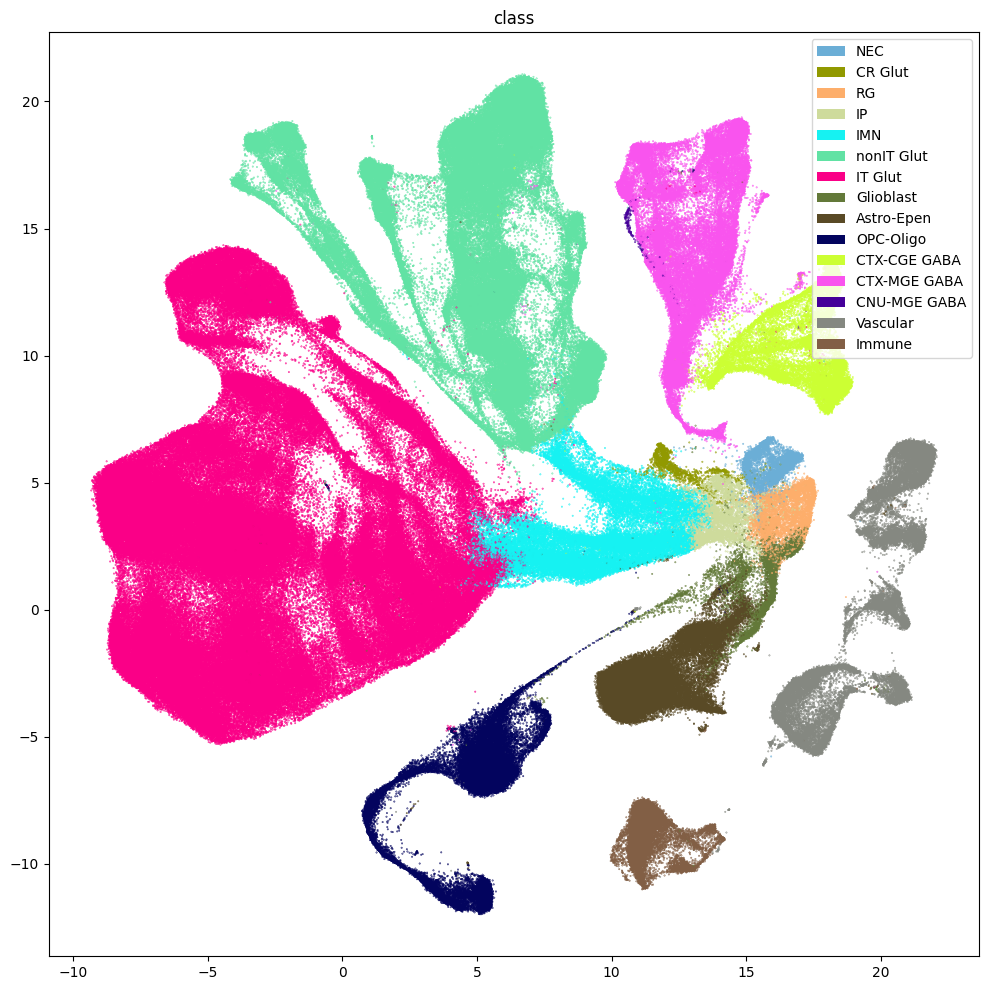

In [32]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['class_color'],
    labels=cell_extended['class'],
    term_orders=cell_extended['class_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("class")
plt.show()

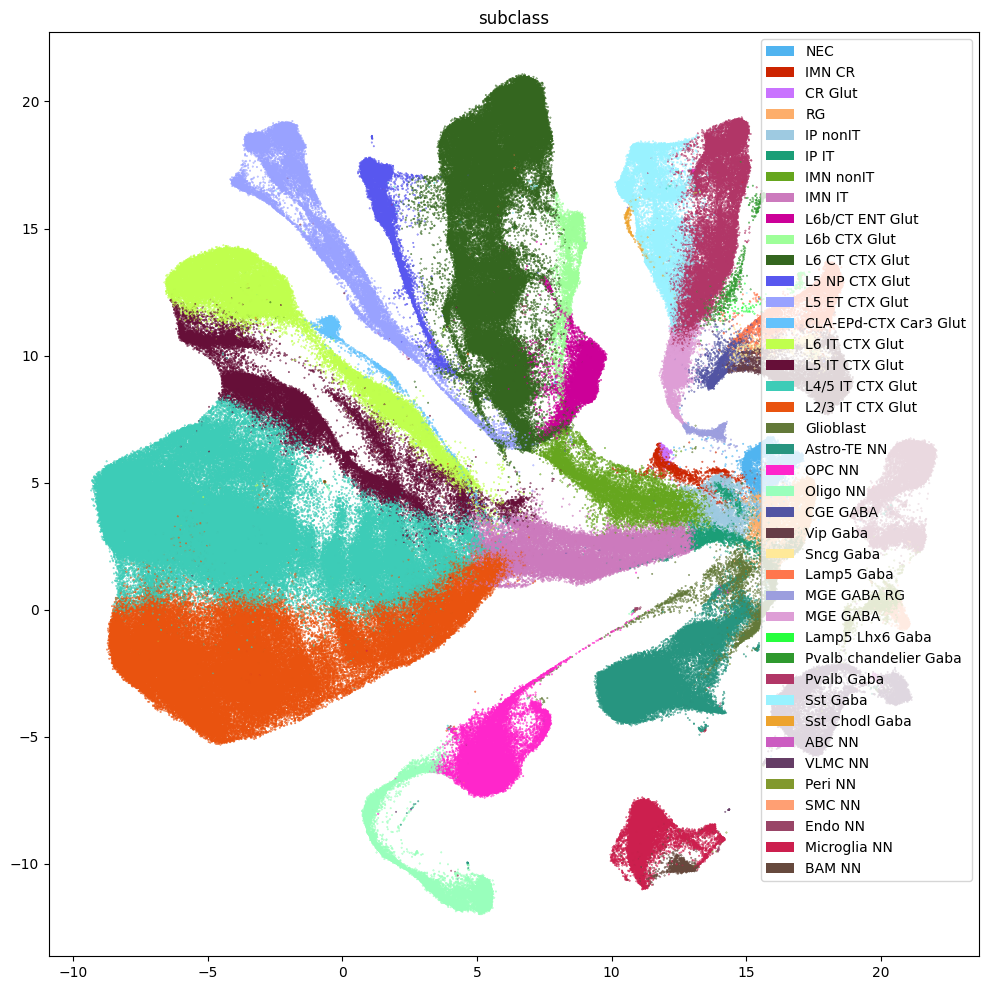

In [33]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['subclass_color'],
    labels=cell_extended['subclass'],
    term_orders=cell_extended['subclass_order'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("subclass")
plt.show()

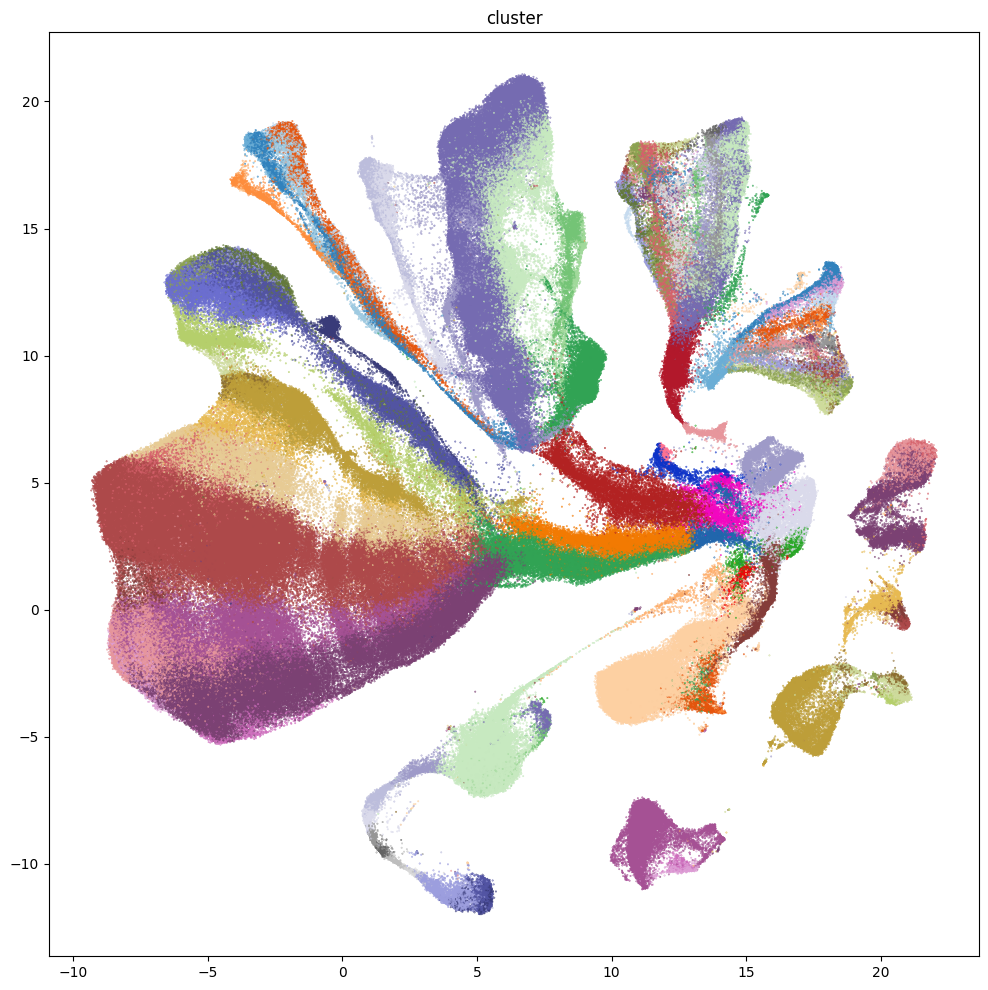

In [34]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['cluster_color'],
    fig_width=12,
    fig_height=12
)
res = ax.set_title("cluster")
plt.show()

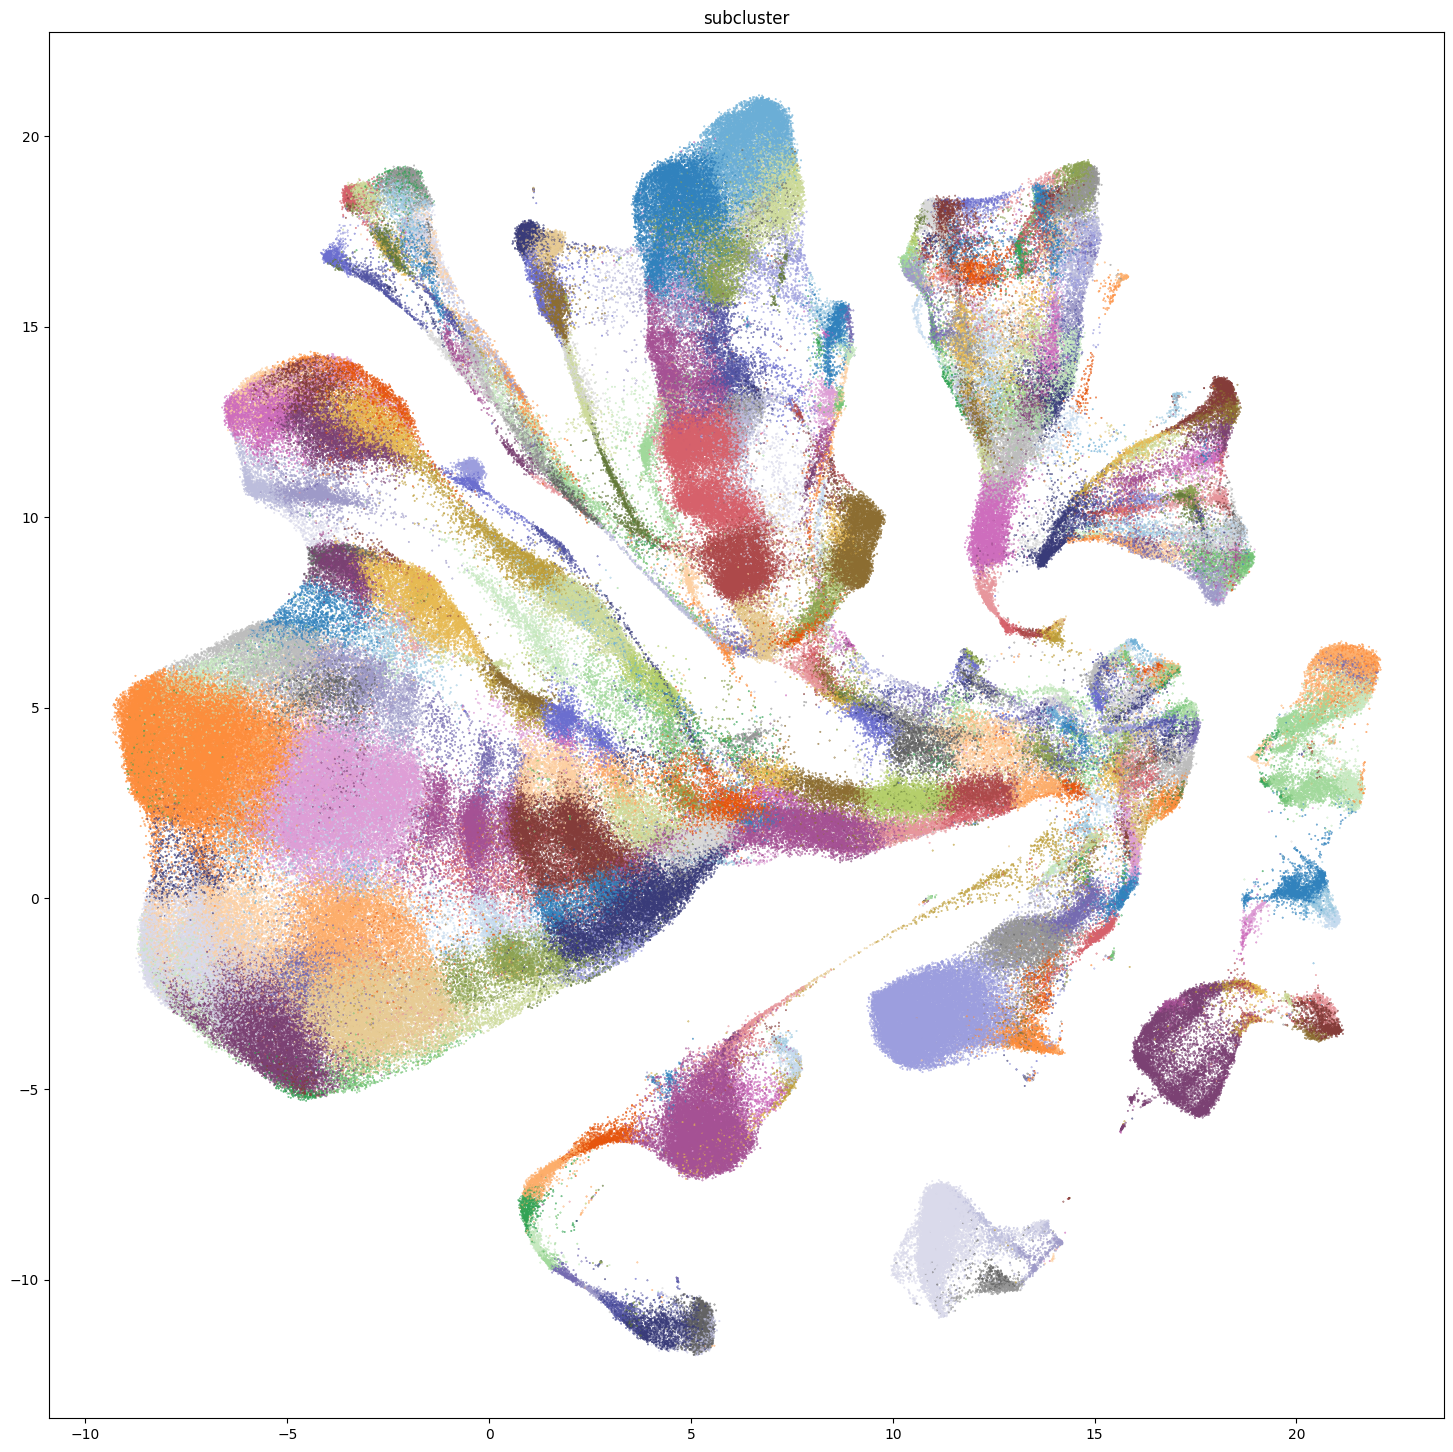

In [35]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['subcluster_color'],
    fig_width=18,
    fig_height=18
)
res = ax.set_title("subcluster")
plt.show()

### Aggregating cluster and cells counts per term per species.

Let's investigate the taxonomy information a bit more. In this section, we'll create bar plots showing the number of subclusters and cells at each level in the taxonomy.

First, we need to compute the number of subclusters that are in each of the cell type taxons above it. This is accomplished by a simple groupby in Pandas.

In [36]:
term_cluster_count = membership_with_cluster_info.reset_index().groupby(
        ['cluster_annotation_term_label']
    )[['cluster_alias']].count()
term_cluster_count.columns = ['number_of_subclusters']
term_cluster_count.head()

number_of_subclusters
cluster_annotation_term_label                       
CS20260131_CLAS_001                               26
CS20260131_CLAS_002                               20
CS20260131_CLAS_003                               30
CS20260131_CLAS_004                               29
CS20260131_CLAS_005                               56

In [37]:
term_cell_count = membership_with_cluster_info.reset_index().groupby(
    ['cluster_annotation_term_label']
)[['number_of_cells']].sum()
term_cell_count.head()

number_of_cells
cluster_annotation_term_label                 
CS20260131_CLAS_001                       4605
CS20260131_CLAS_002                       1611
CS20260131_CLAS_003                       5656
CS20260131_CLAS_004                       4957
CS20260131_CLAS_005                      31718

In [38]:
# Join counts with the term dataframe
term_with_counts = cluster_annotation_term.join(term_cluster_count)
term_with_counts = term_with_counts.join(term_cell_count)
term_with_counts.head()

name cluster_annotation_term_set_label  \
cluster_annotation_term_label                                                   
CS20260131_CLAS_009              Astro-Epen               CCN20260131_LEVEL_0   
CS20260131_CLAS_013            CNU-MGE GABA               CCN20260131_LEVEL_0   
CS20260131_CLAS_002                 CR Glut               CCN20260131_LEVEL_0   
CS20260131_CLAS_011            CTX-CGE GABA               CCN20260131_LEVEL_0   
CS20260131_CLAS_012            CTX-MGE GABA               CCN20260131_LEVEL_0   

                              cluster_annotation_term_set_name  \
cluster_annotation_term_label                                    
CS20260131_CLAS_009                                      class   
CS20260131_CLAS_013                                      class   
CS20260131_CLAS_002                                      class   
CS20260131_CLAS_011                                      class   
CS20260131_CLAS_012                                      class   

                              color_hex_triplet  term_order  term_set_order  \
cluster_annotation_term_label                                                 
CS20260131_CLAS_009                     #594a26           9               0   
CS20260131_CLAS_013                     #450099          13               0   
CS20260131_CLAS_002                     #919900           2               0   
CS20260131_CLAS_011                     #CCFF33          11               0   
CS20260131_CLAS_012                     #f954ee          12               0   

                              parent_term_label parent_term_name  \
cluster_annotation_term_label                                      
CS20260131_CLAS_009                         NaN              NaN   
CS20260131_CLAS_013                         NaN              NaN   
CS20260131_CLAS_002                         NaN              NaN   
CS20260131_CLAS_011                         NaN              NaN   
CS20260131_CLAS_012                         NaN              NaN   

                              parent_term_set_label   CCN20230722_label  \
cluster_annotation_term_label                                             
CS20260131_CLAS_009                             NaN  CS20230722_CLAS_30   
CS20260131_CLAS_013                             NaN  CS20230722_CLAS_08   
CS20260131_CLAS_002                             NaN                 NaN   
CS20260131_CLAS_011                             NaN  CS20230722_CLAS_06   
CS20260131_CLAS_012                             NaN  CS20230722_CLAS_07   

                               number_of_subclusters  number_of_cells  
cluster_annotation_term_label                                          
CS20260131_CLAS_009                               25            32116  
CS20260131_CLAS_013                                3              208  
CS20260131_CLAS_002                               20             1611  
CS20260131_CLAS_011                               52            17567  
CS20260131_CLAS_012                               91            38296

Below we create a function to plot the subcluster and cell counts in a bar graph, coloring by the associated taxon level.

In [39]:
def bar_plot_by_level_and_type(df: pd.DataFrame, level: str, fig_width: float = 8.5, fig_height: float = 4):
    """Plot the number of cells by the specified level.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cluster annotation terms with counts.
    level : str
        The level of the taxonomy to plot (e.g., 'Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster').
    fig_width : float, optional
        Width of the figure in inches. Default is 8.5.
    fig_height : float, optional
        Height of the figure in inches. Default is 4.
    """

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(fig_width, fig_height)

    for idx, ctype in enumerate(['subclusters', 'cells']):

        pred = (df['cluster_annotation_term_set_name'] == level)
        sort_order = np.argsort(df[pred]['term_order'])
        names = df[pred]['name'].iloc[sort_order]
        counts = df[pred]['number_of_%s' % ctype].iloc[sort_order]
        colors = df[pred]['color_hex_triplet'].iloc[sort_order]
        
        ax[idx].barh(names, counts, color=colors)
        ax[idx].set_title('Number of %s by %s' % (ctype,level))
        ax[idx].set_xlabel('Number of %s' % ctype)
        if ctype == 'cells':
            ax[idx].set_xscale('log')
        
        if idx > 0:
            ax[idx].set_yticklabels([])

    return fig, ax

Now let's plot the counts the taxonomy levels class and subclass.

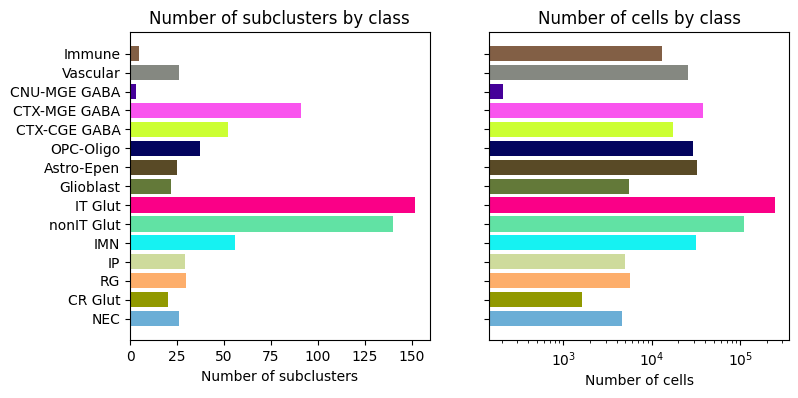

In [40]:
fig, ax = bar_plot_by_level_and_type(term_with_counts, 'class')
plt.show()

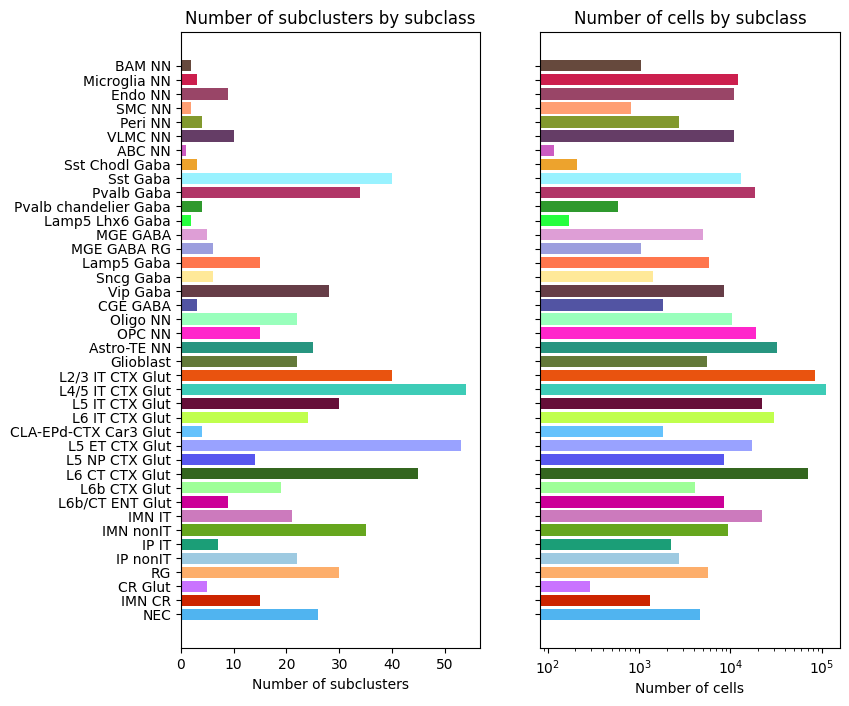

In [41]:
fig, ax = bar_plot_by_level_and_type(
    term_with_counts,
    'subclass',
    fig_height=8
)
plt.show()

### Cluster and subcluster count vs donor age.

Below we compute the number of subclusters and clusters for each of the unique values of age in the dataset. We again compute this by Pandas groupbys.

In [42]:
age_per_subcluster = cell_extended.reset_index().groupby(
        ['donor_age_order']
    )[['cluster_alias']].nunique()
age_per_subcluster.columns = ['number_of_subclusters']
age_per_subcluster.head()

number_of_subclusters
donor_age_order                       
1                                   65
2                                   68
3                                  150
4                                  132
6                                  144

In [43]:
age_per_cluster = cell_extended.reset_index().groupby(
        ['donor_age_order']
    )[['cluster']].nunique()
age_per_cluster.columns = ['number_of_clusters']
age_per_cluster.head()

number_of_clusters
donor_age_order                    
1                                12
2                                13
3                                28
4                                26
6                                26

We finally plot the number of (sub)clusters for each unique age, showing that both are increasing as a function of age.

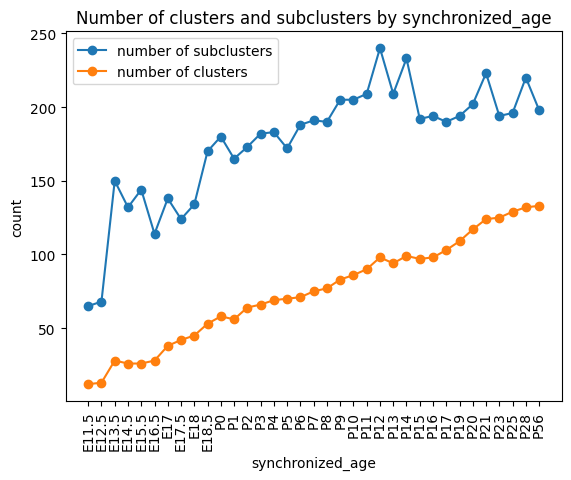

In [44]:
age_values = value_sets[
    value_sets['field'] == 'synchronized_age'
]

figure, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 8)
plt.plot(
    range(35), age_per_subcluster['number_of_subclusters'], linestyle='-', marker='o', label='number of subclusters'
)
plt.plot(
    range(35), age_per_cluster['number_of_clusters'], linestyle='-', marker='o', label='number of clusters'
)
_ = ax.set_xticks(range(35))
_ = ax.set_xticklabels(age_values.reset_index().set_index('order').loc[age_per_cluster.index, 'label'], rotation=90)
ax.set_xlabel('synchronized_age')
ax.set_ylabel('count')
plt.title("Number of clusters and subclusters by synchronized_age")
plt.legend(loc=0)

### Visualizing the developmental visual cortex taxonomy

Term sets: class, subclass, cluster, and subcluster define the Developing Mouse, Visual Cortex taxonomy. We can visualize the taxonomy as a sunburst diagram that shows the single inheritance hierarchy through a series of rings, that are sliced for each annotation term. Each ring corresponds to a level in the hierarchy. We have ordered the rings so that the class level. Rings are divided based on their hierarchical relationship to the parent slice.

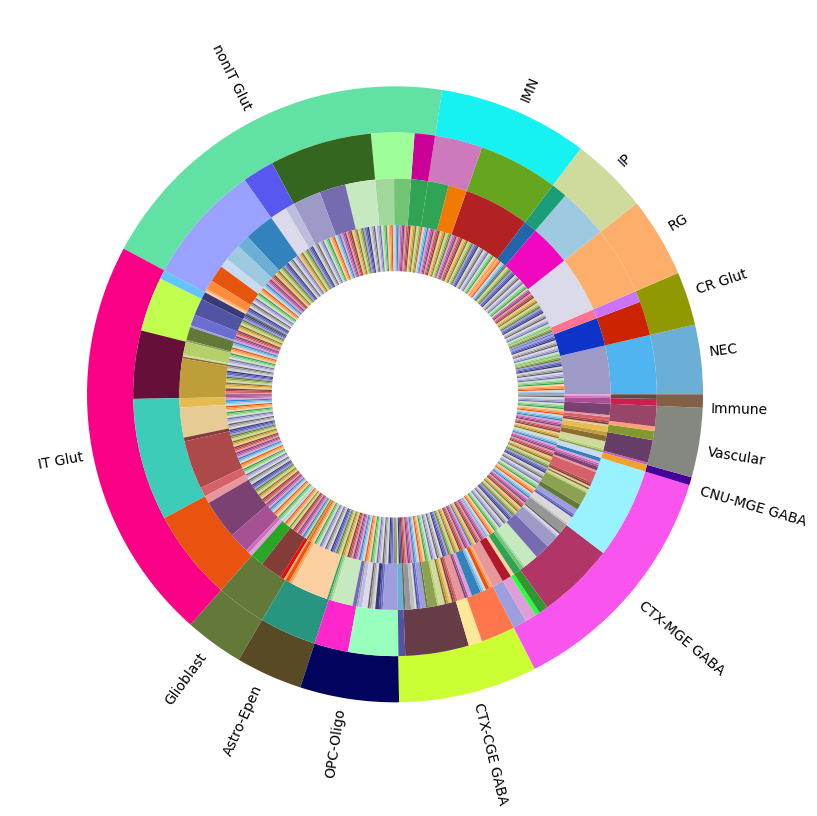

In [45]:
levels = ['class', 'subclass', 'cluster', 'subcluster']
df = {}

# Copy the term order of the parent into each of the level below it.
if term_with_counts.index.name != 'cluster_annotation_term_label':
    term_with_counts = term_with_counts.set_index('cluster_annotation_term_label')
term_with_counts['parent_order'] = ""
for idx, row in term_with_counts.iterrows():
    if pd.isna(row['parent_term_label']):
        continue
    term_with_counts.loc[idx, 'parent_order'] = term_with_counts.loc[row['parent_term_label']]['term_order']

term_with_counts = term_with_counts.reset_index()
for lvl in levels:
    pred = term_with_counts['cluster_annotation_term_set_name'] == lvl
    df[lvl] = term_with_counts[pred]
    df[lvl] = df[lvl].sort_values(['parent_order', 'term_order'])

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
size = 0.15

for i, lvl in enumerate(levels):
    
    if lvl == 'class':
        ax.pie(df[lvl]['number_of_subclusters'],
               colors=df[lvl]['color_hex_triplet'],
               labels = df[lvl]['name'],
               rotatelabels=True,
               labeldistance=1.025,
               radius=1,
               wedgeprops=dict(width=size, edgecolor=None),
               startangle=0)
    else :
        ax.pie(df[lvl]['number_of_subclusters'],
               colors=df[lvl]['color_hex_triplet'],
               radius=1-i*size,
               wedgeprops=dict(width=size, edgecolor=None),
               startangle=0)
term_with_counts = term_with_counts.set_index('cluster_annotation_term_label')
plt.show()

In the next tutorial, we show how to access and use [Deveolping Mouse gene expression data](https://alleninstitute.github.io/abc_atlas_access/notebooks/dev_mouse_vis_cortex_10X_scRNASeq_tutorial.html).